In [1]:
# S3 bucket and prefix
bucket = 'bituslabs-team-ai'
prefix = 'sagemaker/DEMO-data-distribution-types'

# Define IAM role
from sagemaker import get_execution_role

role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import io
import time
import copy
import sagemaker.amazon.common as smac
import os

In [3]:
def get_gdelt(filename):
    df = pd.read_csv(filename, sep=',', low_memory=False)
    return df

data = get_gdelt('gdelt_1979.csv')
data

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,190920,19790626,197906,1979,1979.4822,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,NaN,RB,RB,0.0000,0.0000,0.0,20130203.0,unspecified
1,65410,19790306,197903,1979,1979.1808,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,Laos,LA,LA,18.0000,105.0000,0.0,20130203.0,unspecified
2,230365794,19790212,197902,1979,1979.1151,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,Ghana,GH,GH,8.0000,-2.0000,0.0,20130206.0,unspecified
3,144299,19790518,197905,1979,1979.3781,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,India,IN,IN,20.0000,77.0000,0.0,20130203.0,unspecified
4,372325,19791208,197912,1979,1979.9260,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,Italy,IT,IT,42.8333,12.8333,0.0,20130203.0,unspecified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145337,211860,19790713,197907,1979,1979.5288,VNM,VIETNAMESE,VNM,NaN,NaN,...,-1937567.0,5.0,"Yunnan Province, Yunnan, China",CH,CH29,25.0000,102.0000,NaN,20130203.0,unspecified
145338,48901,19790218,197902,1979,1979.1315,VNM,VIETNAMESE,VNM,NaN,NaN,...,10054122.0,4.0,"Chen Chu, Zhejiang, China",CH,CH02,27.4888,120.6010,10054122.0,20130203.0,unspecified
145339,153556,19790525,197905,1979,1979.3973,NAM,NAMIBIA,NAM,NaN,NaN,...,0.0,1.0,Namibia,WA,WA,-22.0000,17.0000,0.0,20130203.0,unspecified
145340,104636,19790411,197904,1979,1979.2767,ISR,ISRAELI,ISR,NaN,NaN,...,0.0,1.0,West Bank,WE,WE,31.6667,35.2500,0.0,20130203.0,unspecified


EventCode


col_0,% observations
EventCode,
10,0.058311
11,0.001493
12,0.011820
13,0.013121
14,0.006330
...,...
1724,0.000131
1821,0.000282
1822,0.000654


,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Lat,Actor2Geo_Long
count,145342.000000,145342.000000,145341.000000,145341.000000,145341.000000,145341.000000
mean,4.269323,4.912426,24.503867,24.820963,21.585776,22.581891
std,3.047717,2.691235,22.484809,58.321269,22.511396,54.969635
min,1.000000,0.000000,-85.622100,-179.050000,-85.622100,-179.050000
25%,2.000000,3.026316,7.616670,0.000000,0.000000,0.000000
50%,3.000000,4.735376,31.131600,25.000000,25.000000,19.933300
75%,6.000000,6.484642,41.000000,49.462200,39.831400,45.233300
max,36.000000,23.529412,85.000000,180.000000,85.000000,180.000000


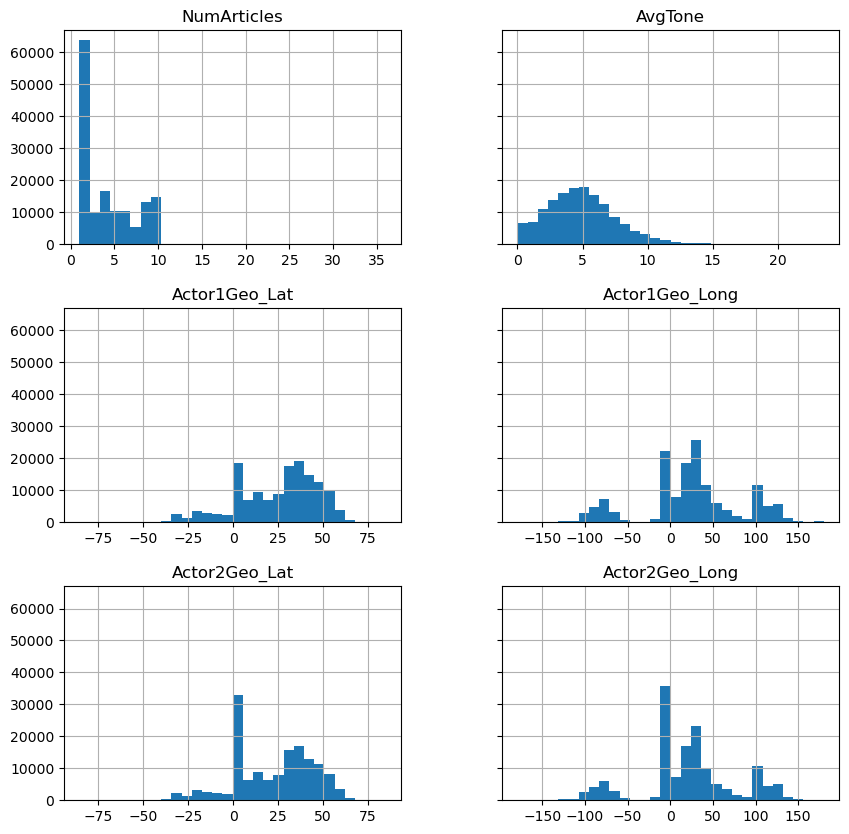

In [7]:
data = data[['EventCode', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']].copy()
data['EventCode'] = data['EventCode'].astype(object)

for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

display(data.describe())
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))
plt.show()

In [9]:
events = pd.crosstab(index=data['EventCode'], columns='count').sort_values(by='count', ascending=False).index[:20]
print(events)

Index([ 42,  43,  40,  46,  10,  51, 190,  36,  20,  57, 173, 120,  30, 111,
       112,  13, 193,  12,  50, 110],
      dtype='int64', name='EventCode')


Perform the same process for other years of data.

In [10]:
def write_to_s3(bucket, prefix, channel, file_prefix, X, y):
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, X.astype('float32'), y.astype('float32'))
    buf.seek(0)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, channel, file_prefix + '.data')).upload_fileobj(buf)


def transform_gdelt(df, events=None):
    df = df[['AvgTone', 'EventCode', 'NumArticles', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']].copy()
    df['EventCode'] = df['EventCode'].astype(object)
    if events is not None:
        df = df[np.in1d(df['EventCode'], events)]
    return pd.get_dummies(df[((df['Actor1Geo_Lat'] == 0) & (df['Actor1Geo_Long'] == 0) != True) & 
        ((df['Actor2Geo_Lat'] == 0) & (df['Actor2Geo_Long'] == 0) != True)])


def prepare_gdelt(bucket, prefix, file_prefix, events=None, random_state=1729):
    df = get_gdelt(f'gdelt_{file_prefix}.csv')
    model_data = transform_gdelt(df, events)
    train_data, validation_data = np.split(model_data.sample(frac=1, random_state=random_state).values, 
                                           [int(0.9 * len(model_data))])

    write_to_s3(bucket, prefix, 'train', file_prefix, train_data[:, 1:], train_data[:, 0])
    write_to_s3(bucket, prefix, 'validation', file_prefix, validation_data[:, 1:], validation_data[:, 0])

for year in range(1979, 1984):
    print(year)
    prepare_gdelt(bucket, prefix, str(year), events)

1979
1980
1981
1982
1983


In [11]:
containers = {'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/linear-learner:latest',
              'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:latest',
              'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/linear-learner:latest',
              'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/linear-learner:latest'}
container = containers[boto3.Session().region_name]

In [16]:
common_training_params = {
    "RoleArn": role,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 5,
        "InstanceType": "ml.c4.2xlarge",#,#"ml.t3.medium",#"ml.c5.xlarge",#"ml.m4.xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix)
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "HyperParameters": {
        "feature_dim": "25",
        "mini_batch_size": "500",
        "predictor_type": "regressor",
        "epochs": "2",
        "num_models": "32",
        "loss": "absolute_loss"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    }
}

In [17]:
sharded_job = 'DEMO-linear-sharded-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", sharded_job)

sharded_training_params = copy.deepcopy(common_training_params)
sharded_training_params['TrainingJobName'] = sharded_job
sharded_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'ShardedByS3Key'

Job name is: DEMO-linear-sharded-2025-08-24-07-41-13


In [18]:
replicated_job = 'DEMO-linear-replicated-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", replicated_job)

replicated_training_params = copy.deepcopy(common_training_params)
replicated_training_params['TrainingJobName'] = replicated_job
replicated_training_params['InputDataConfig'][0]['DataSource']['S3DataSource']['S3DataDistributionType'] = 'FullyReplicated'

Job name is: DEMO-linear-replicated-2025-08-24-07-41-13


In [ ]:
%%time

region = boto3.Session().region_name
sm = boto3.Session().client('sagemaker')

job_name = sharded_training_params['TrainingJobName']

sm.create_training_job(**sharded_training_params)

# sm.create_training_job(**replicated_training_params)

status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)

status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print("Training job ended with status: " + status)

if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
